# Renewable Energy GCPBBB Grid Connected Photo Sensor Project

This notebook implements the Machine Learning pipeline for optimizing renewable energy integration. 
It covers data generation (calibrated with Mendeley data), feature engineering, model training, and evaluation for:
1. Energy Predictor (Regression)
2. Balancing Classifier (XGBoost)
3. Grid Stability Monitor (Classification)

In [8]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Add src to path to import modules
sys.path.append(os.path.abspath('../src'))

from data_loader import generate_synthetic_data, get_real_world_stats, load_stability_data
from preprocessing import preprocess_features, prepare_datasets
from model import train_energy_predictor, train_balancing_classifier, train_stability_monitor

# Ensure output directories exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../documents/figures', exist_ok=True)

# Update plot settings
plt.rcParams['figure.figsize'] = (10, 6)

In [9]:
def plot_classification_metrics(model, X_test, y_test, model_name, feature_names=None, output_dir='../documents/figures'):
    """
    Generates and saves ROC, Precision-Recall, and Feature Importance plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Feature Importance
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        plt.figure(figsize=(10, 6))
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(X_test.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_test.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{model_name.lower().replace(" ", "_")}_feature_importance.png'))
        plt.show()
        plt.close()

    # 2. ROC and PR Curves (Multiclass)
    # Binarize the output
    classes = np.unique(y_test)
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Get probabilities
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        print(f"Model {model_name} does not support predict_proba, skipping ROC/PR curves.")
        return

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(output_dir, f'{model_name.lower().replace(" ", "_")}_roc.png'))
    plt.show()
    plt.close()

    # Precision-Recall Curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'PR curve of class {classes[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.savefig(os.path.join(output_dir, f'{model_name.lower().replace(" ", "_")}_pr.png'))
    plt.show()
    plt.close()
    
    # 3. Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(output_dir, f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png'))
    plt.show()
    plt.close()

## 1. Data Generation (Calibrated)
We load real-world statistics from the Mendeley dataset to calibrate our synthetic data generation.

In [10]:
print("Loading Real-World Data for Calibration...")
# Note: We assume the notebook is running from 'notebooks/' so dataset is at '../dataset'
real_stats = get_real_world_stats('../dataset')

print("Generating calibrated synthetic data...")
# Generate 1 month of data
n_samples = 1440 * 30 
data = generate_synthetic_data(n_samples, real_stats=real_stats)
print(f"Generated {len(data)} samples.")
data.head()

Loading Real-World Data for Calibration...
Loading Mendeley data from ../dataset...
Derived Real-World Stats -- Peak Power: 215.71W, Mean V: 88.10V
Generating calibrated synthetic data...
Generated 43200 samples.


,Timestamp,Irradiance,Temperature,Grid_Consumption,Battery_SoC,Generated_Power
0,2023-01-01 00:00:00,0.000000,14.384850,1204.149562,50.000000,0.000000
1,2023-01-01 00:01:00,0.000000,14.735834,1054.949768,48.945050,0.000000
2,2023-01-01 00:02:00,2.903249,10.567610,1269.340514,47.707023,0.626257
3,2023-01-01 00:03:00,101.825652,16.240841,1192.337357,47.612921,21.964716
4,2023-01-01 00:04:00,33.893628,13.168349,1121.435217,46.857044,7.311163


## 1.1 Exploratory Data Analysis (EDA)
Visualize distributions and correlations to match report figures.

In [ ]:
# EDA: Distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['Irradiance'], kde=True, color='orange')
plt.title('Irradiance Distribution')

plt.subplot(1, 3, 2)
sns.histplot(data['Grid_Consumption'], kde=True, color='blue')
plt.title('Grid Consumption Distribution')

plt.subplot(1, 3, 3)
sns.histplot(data['Battery_SoC'], kde=True, color='green')
plt.title('Battery SoC Distribution')

plt.tight_layout()
os.makedirs('../documents/figures', exist_ok=True)
plt.savefig('../documents/figures/eda_distributions.png')
plt.show()
plt.close()

# EDA: Correlation Matrix
plt.figure(figsize=(10, 8))
corr = data[['Irradiance', 'Temperature', 'Grid_Consumption', 'Battery_SoC', 'Generated_Power']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('../documents/figures/eda_correlation.png')
plt.show()
plt.close()

# EDA: Time Series Sample (First 2 days)
plt.figure(figsize=(12, 6))
subset = data.iloc[:2880] # 2 days * 1440 mins
plt.plot(subset['Grid_Consumption'], label='Grid Consumption', alpha=0.7)
plt.plot(subset['Generated_Power']*30, label='Solar Generation (30 panels)', alpha=0.7)
plt.title('48-Hour Energy Profile')
plt.legend()
plt.tight_layout()
plt.savefig('../documents/figures/eda_timeseries.png')
plt.show()
plt.close()

## 2. Feature Engineering
We add time-based features and lag features to capture temporal dependencies.

In [11]:
print("Preprocessing data...")
data_processed = preprocess_features(data.copy())
print(f"Data shape after preprocessing: {data_processed.shape}")

Preprocessing data...
Data shape after preprocessing: (43185, 14)


## 3. Model Development

### 3.1 Energy Predictor (Random Forest)
Predicts the next step's Grid Consumption.

Training Grid Consumption Predictor...
Grid Consumption MAE: 42.1918


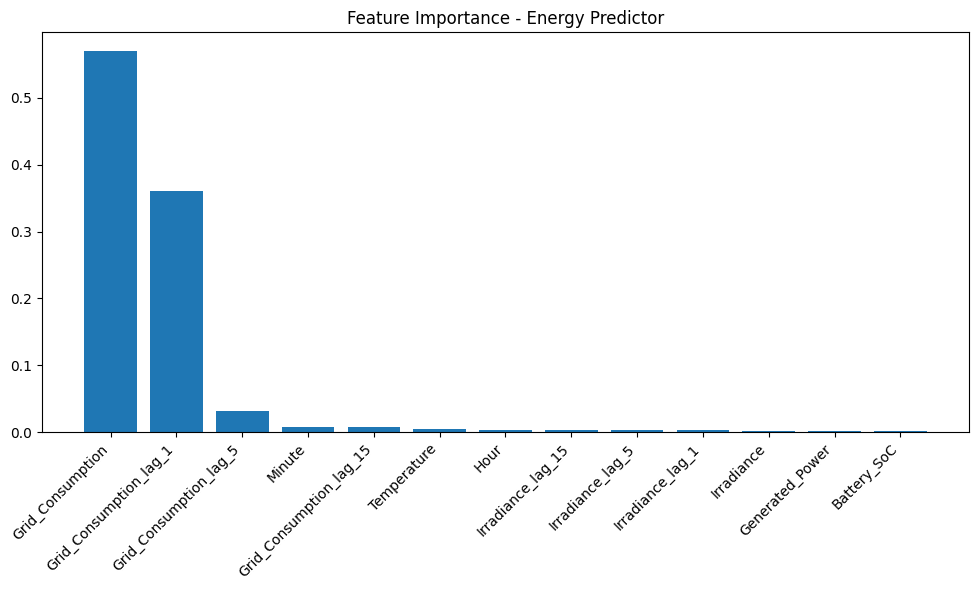

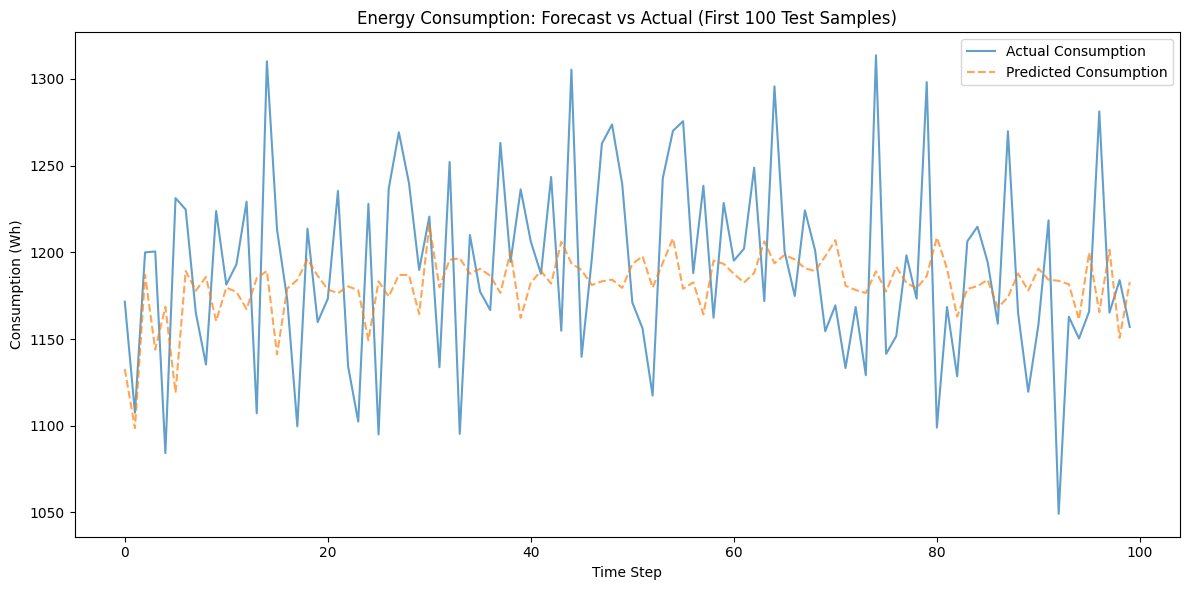

['../models/scaler_reg.pkl']

In [12]:
# Create target: Next step consumption
data_processed['Target_Consumption'] = data_processed['Grid_Consumption'].shift(-1)
data_reg = data_processed.dropna()

X_train_reg, X_test_reg, y_train_reg, y_test_reg, scaler_reg, feature_cols_reg = prepare_datasets(
    data_reg, 'Target_Consumption'
)

print("Training Grid Consumption Predictor...")
model_reg = train_energy_predictor(X_train_reg, y_train_reg)

# Evaluate
y_pred_reg = model_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Grid Consumption MAE: {mae:.4f}")

# Plot Feature Importance
if hasattr(model_reg, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    importances = model_reg.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title('Feature Importance - Energy Predictor')
    plt.bar(range(X_test_reg.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_test_reg.shape[1]), [feature_cols_reg[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../documents/figures/energy_predictor_feature_importance.png')
    plt.show()
    plt.close()

# Plot Forecast vs Actual (Time Series)
plt.figure(figsize=(12, 6))
subset_n = 100
plt.plot(range(subset_n), y_test_reg.iloc[:subset_n], label='Actual Consumption', alpha=0.7)
plt.plot(range(subset_n), y_pred_reg[:subset_n], label='Predicted Consumption', alpha=0.7, linestyle='--')
plt.title('Energy Consumption: Forecast vs Actual (First 100 Test Samples)')
plt.xlabel('Time Step')
plt.ylabel('Consumption (Wh)')
plt.legend()
plt.tight_layout()
plt.savefig('../documents/figures/energy_forecast_vs_actual.png')
plt.show()
plt.close()

# Save
joblib.dump(model_reg, '../models/energy_predictor.pkl')
joblib.dump(scaler_reg, '../models/scaler_reg.pkl')

### 3.2 Balancing Classifier (XGBoost)
Predicts the optimal battery action: 0 (Discharge), 1 (Hold), 2 (Charge).
Currently uses realistic threshold logic: Net Power > 10W -> Charge, < -10W -> Discharge.


--- DEBUG: Label Distribution ---
Total Signals:
Signal
0    22338
2    20755
1       92
Name: count, dtype: int64
---------------------------------
Training Balancing Signal Classifier...


/Users/nisaljinadasa/Documents/Coding/ML Project/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:18:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Balancing Classifier Accuracy: 0.9984
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4475
           1       0.80      0.31      0.44        13
           2       1.00      1.00      1.00      4149

    accuracy                           1.00      8637
   macro avg       0.93      0.77      0.81      8637
weighted avg       1.00      1.00      1.00      8637



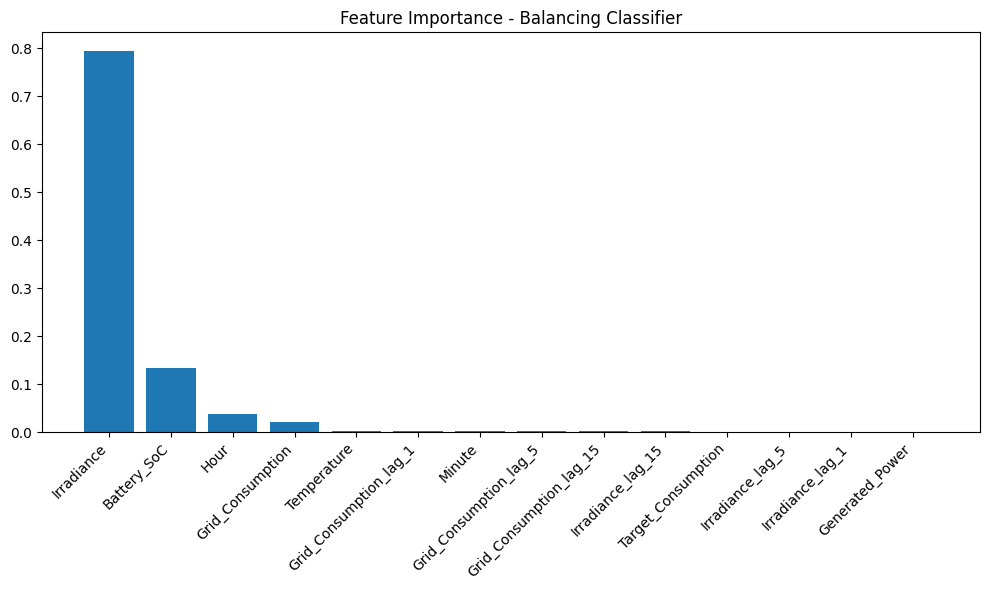

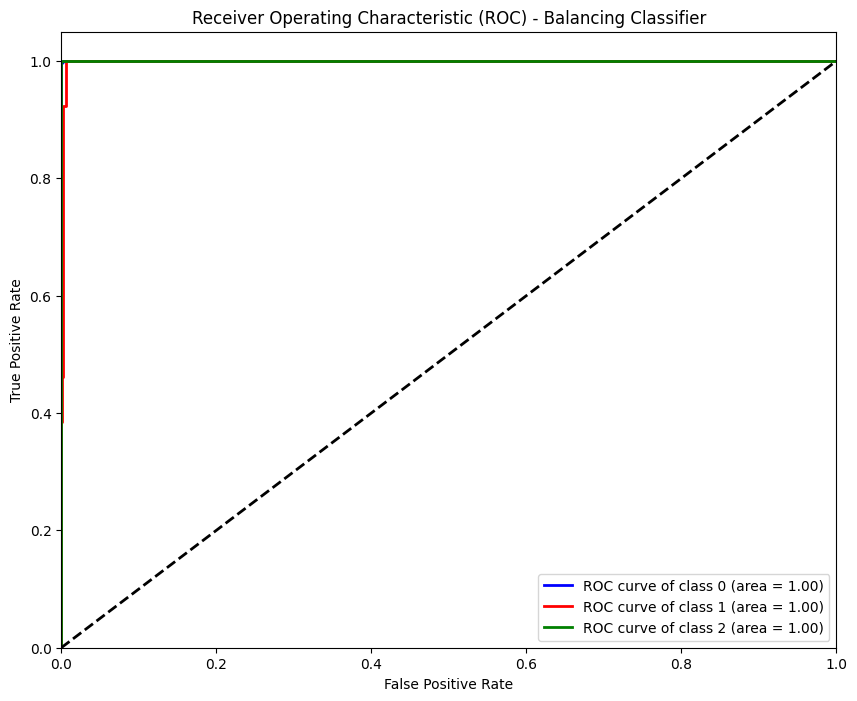

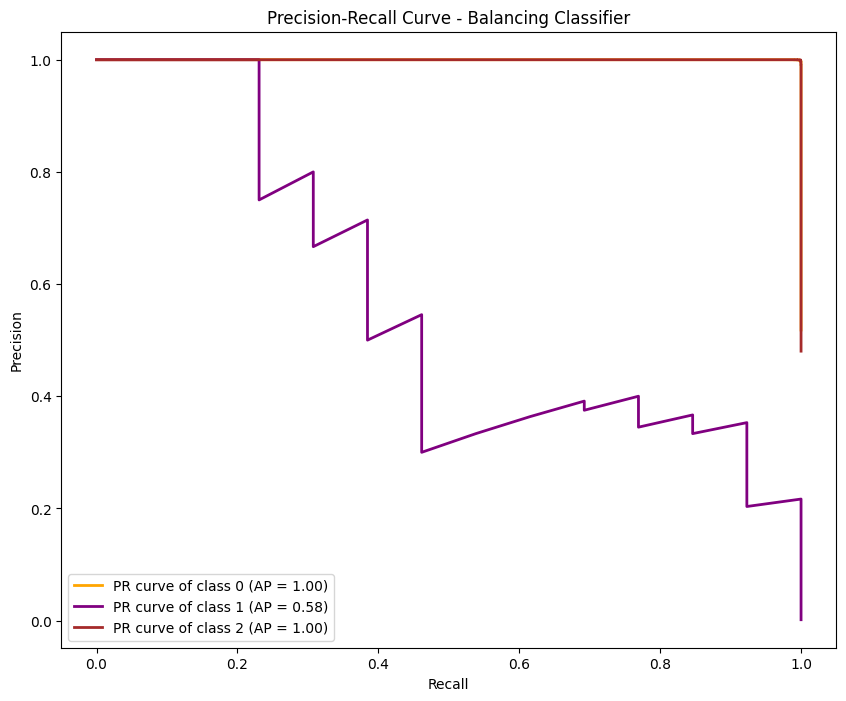

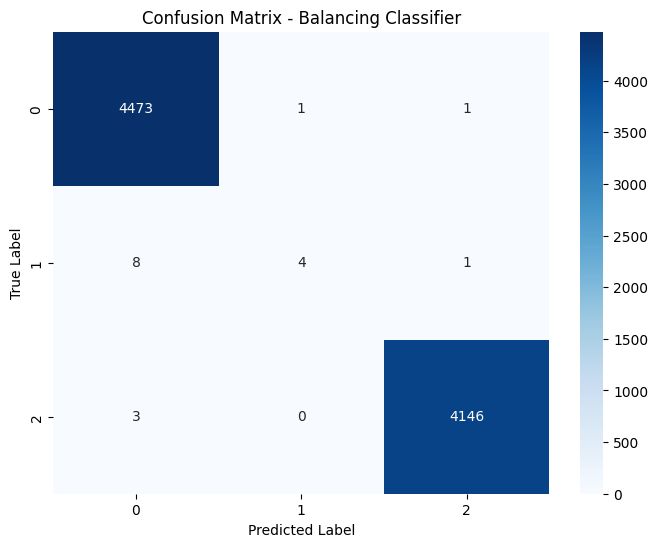

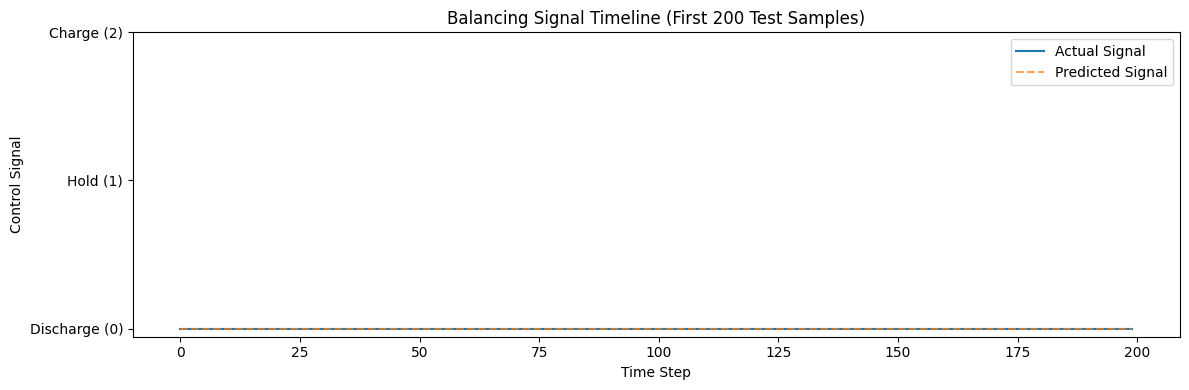

['../models/scaler_clf.pkl']

In [13]:
# Define Balancing Logic (Labels)
def get_balancing_signal(row):
    # Economical Logic:
    # Net Power = Generation - Consumption
    # If Net Power > 0 (Surplus) -> Charge (2)
    # If Net Power < 0 (Deficit) -> Discharge (0)
    # If Net Power ~ 0 -> Hold (1)
    
    # Use the same system size as dashboard (30 panels)
    generation = row['Generated_Power'] * 30 
    consumption = row['Grid_Consumption']
    net_power = generation - consumption
    
    if net_power > 10: # Surplus
        return 2 # Charge
    elif net_power < -10: # Deficit
        return 0 # Discharge
    else:
        return 1 # Hold

data_clf = data_processed.copy()
data_clf['Signal'] = data_clf.apply(get_balancing_signal, axis=1)

# DEBUG: Check Label Distribution
print("\n--- DEBUG: Label Distribution ---")
print("Total Signals:")
print(data_clf['Signal'].value_counts())
print("---------------------------------")

X_train_clf, X_test_clf, y_train_clf, y_test_clf, scaler_clf, feature_cols_clf = prepare_datasets(
    data_clf, 'Signal', is_classification=True
)

print("Training Balancing Signal Classifier...")
model_clf = train_balancing_classifier(X_train_clf, y_train_clf)

# Evaluate
y_pred_clf = model_clf.predict(X_test_clf)
acc = accuracy_score(y_test_clf, y_pred_clf)
print(f"Balancing Classifier Accuracy: {acc:.4f}")
print(classification_report(y_test_clf, y_pred_clf))

# Plot Advanced Metrics
plot_classification_metrics(model_clf, X_test_clf, y_test_clf, "Balancing Classifier", feature_names=feature_cols_clf, output_dir='../output')

# Plot Balancing Signal Timeline
plt.figure(figsize=(12, 4))
subset_n = 200
plt.step(range(subset_n), y_test_clf.iloc[:subset_n], where='mid', label='Actual Signal')
plt.step(range(subset_n), y_pred_clf[:subset_n], where='mid', label='Predicted Signal', linestyle='--', alpha=0.7)
plt.yticks([0, 1, 2], ['Discharge (0)', 'Hold (1)', 'Charge (2)'])
plt.title('Balancing Signal Timeline (First 200 Test Samples)')
plt.xlabel('Time Step')
plt.ylabel('Control Signal')
plt.legend()
plt.tight_layout()
plt.savefig('../documents/figures/balancing_signal_timeline.png')
plt.show()
plt.close()

# Save
joblib.dump(model_clf, '../models/balancing_classifier.pkl')
joblib.dump(scaler_clf, '../models/scaler_clf.pkl')

### 3.3 Grid Stability Monitor (Random Forest)
Trains on real data (using sliding window statistics) top predict faults (F0=Stable, F1-F7=Unstable).


Training Grid Stability Monitor (Real Data)...
Loading Stability Data from ../dataset...
Grid Stability Monitor Accuracy: 0.9791
              precision    recall  f1-score   support

          F0       0.98      0.99      0.99      2863
          F1       0.99      1.00      0.99      2649
          F2       0.98      0.96      0.97      2924
          F3       0.96      0.95      0.96      1747
          F4       1.00      1.00      1.00      2911
          F5       0.98      0.97      0.98      2836
          F6       0.98      0.99      0.99      2853
          F7       0.95      0.97      0.96      2850

    accuracy                           0.98     21633
   macro avg       0.98      0.98      0.98     21633
weighted avg       0.98      0.98      0.98     21633



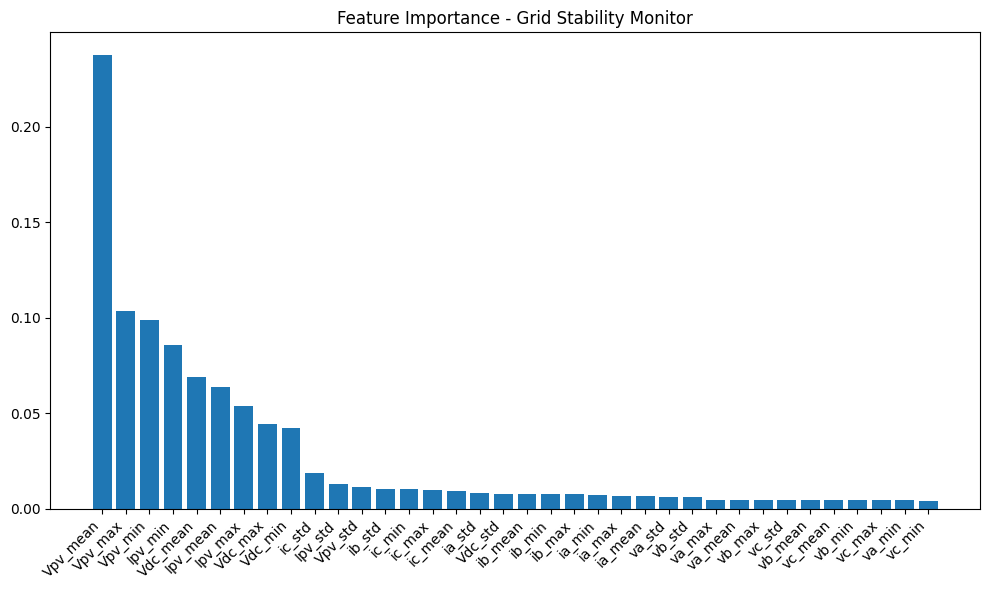

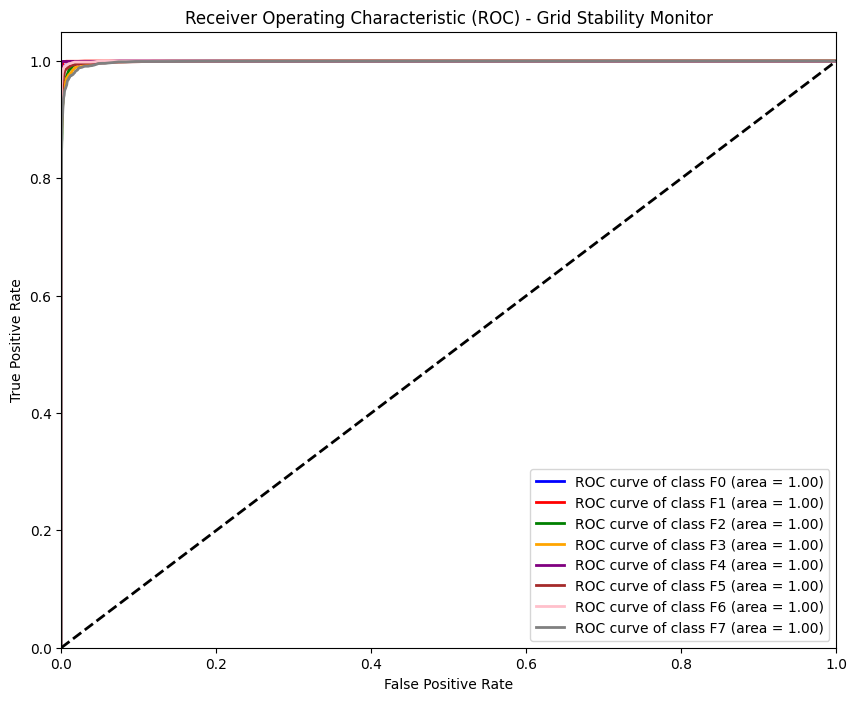

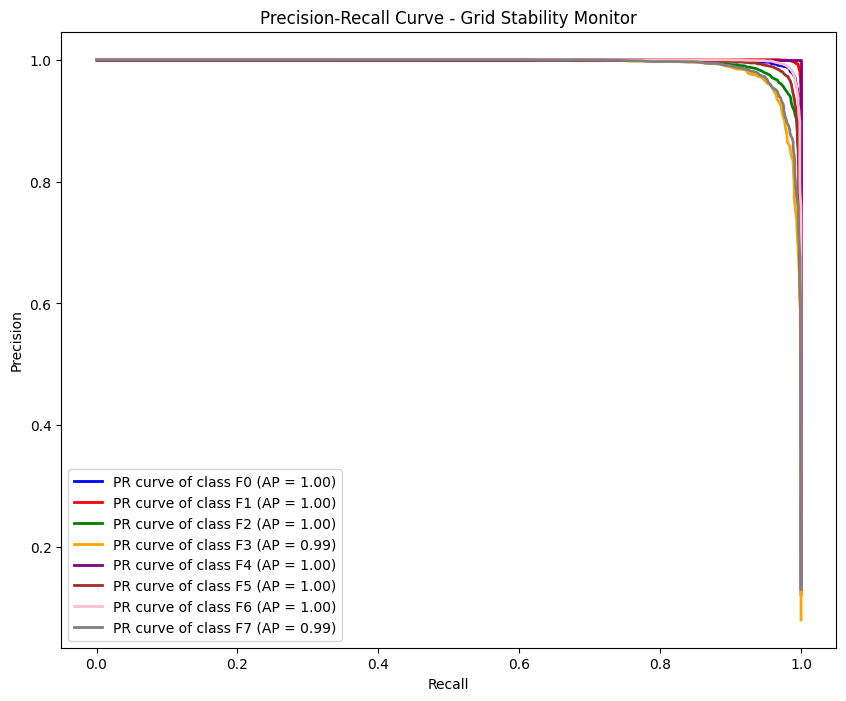

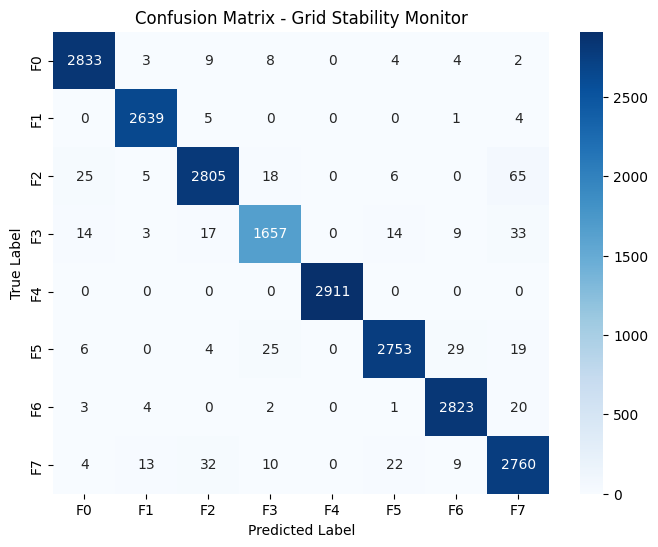

In [14]:
print("\nTraining Grid Stability Monitor (Real Data)...")
# MATCH INFERENCE WINDOW: Inference uses a buffer of 20 steps.
# Training must use the same window size to learn the correct feature distributions (std, min, max).
stability_data = load_stability_data('../dataset', window_size=20)

if not stability_data.empty:
    # Prepare Data
    # Target: Fault_Type (We treat F0 as Stable, F1-F7 as Unstable/Faulty)
    # Features: All columns ending in _mean, _std, _max, _min
    
    feature_cols_stability = [c for c in stability_data.columns if c.endswith(('_mean', '_std', '_max', '_min'))]
    X_stability = stability_data[feature_cols_stability]
    y_stability = stability_data['Fault_Type']
    
    # Split
    from sklearn.model_selection import train_test_split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_stability, y_stability, test_size=0.2, random_state=42)
    
    # Train
    model_stability = train_stability_monitor(X_train_s, y_train_s)
    
    # Evaluate
    y_pred_s = model_stability.predict(X_test_s)
    acc_s = accuracy_score(y_test_s, y_pred_s)
    print(f"Grid Stability Monitor Accuracy: {acc_s:.4f}")
    print(classification_report(y_test_s, y_pred_s))
    
    # Plot Advanced Metrics
    plot_classification_metrics(model_stability, X_test_s, y_test_s, "Grid Stability Monitor", feature_names=feature_cols_stability, output_dir='../output')
    
    # Save
    joblib.dump(model_stability, '../models/stability_monitor.pkl')
    # Save feature names for inference
    joblib.dump(feature_cols_stability, '../models/stability_features.pkl')
else:
    print("No stability data found. Skipping Stability Monitor training.")

## 4. Conclusion
The training pipeline is complete. Models are saved in `models/` and evaluation plots in `output/`.